# Загрузка данных

In [1379]:
graphics_color = '#b683ff'

In [1380]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.graph_objs as go
import numpy as np
import matplotlib.cbook as cbook

In [1381]:
df = pd.read_csv('T_games_dataset.csv')
# df = df[df['order_day'].apply(lambda x: x.split('-')[0] )]
df.head()

,id,client_id,order_day,category_id,category_name,good_id,good_name,good_price,good_cnt,gender_cd,age,education_level,city_nm,monthly_income_amt,steam_popularity_score
0,1500571355,5-25R6ZT3L9,2023-05-22,29688,Скидки,890257,The Night of the Rabbit,299.00,1.0,M,28,UGR,Москва,73552,0.0
1,1500571245,5-2P4Z5VSMF,2023-05-22,28574,Ролевые (RPG),1436296,Ni no Kuni Wrath of the White Witch Remastered,269.85,1.0,M,26,GRD,Москва,281417,0.0
2,1500573164,5-YGO64ONA,2023-05-24,30659,Казуальные игры,1179848,KeyWe - The 100th Annual Grand Ol' Telepost To...,77.00,1.0,M,30,GRD,Москва,86000,0.0
3,1500364601,5-1VA0D94LX,2022-10-23,29688,Скидки,1204914,GTFO,1675.01,1.0,M,24,GRD,Самара,56000,283.0
4,1500288143,5-1QCUV9SY7,2022-07-03,28577,Экшн,1314503,Neon White,550.00,1.0,M,38,GRD,Санкт-Петербург,32000,1676.0


Размеры перед предобработкой:

In [1382]:
n_purchases, n_users = df.shape[0], df['client_id'].nunique()
print('Number of purchases: {}'.format(n_purchases))
print('Number of users: {}'.format(n_users))

Number of purchases: 88699
Number of users: 41298


In [1383]:
df['good_type'] = df['good_name'].apply(
    lambda x: 'DLC' if 'dlc' in x.lower() else 'Game')
df['is_DLC'] = df['good_type'] == 'DLC'

bundle_tags = ['edition', 'pack', 'collection', 'bundle', 'antology']

df['is_bundle'] = df['good_name'].apply(lambda x: (
    any(tag in x.lower() for tag in bundle_tags)) and ('dlc' not in x.lower()))

bundle_purchases = df[df['is_bundle']].copy()
bundle_purchases['is_DLC'] = True
bundle_purchases['good_name'] = bundle_purchases['good_name'].apply(
    lambda x: x + ' (dlc from bundle)')
df = pd.concat([df, bundle_purchases], axis=0)

donut = ['pass', 'coins', 'запасные детали', 'кейс', 'ключ']
df.loc[df['good_name'].apply(lambda x : any([tag in x.lower() for tag in donut])), 'is_DLC'] = False

edu_lvl_grade = {'SCH': 1, 'UGR': 2, 'GRD': 3, 'PGR': 4, 'ACD': 5}
edu_lvl_by_grade = {v: k for k, v in edu_lvl_grade.items()}

df['edu_lvl_grade'] = df['education_level'].map(edu_lvl_grade)

min_age_by_id = df.groupby('client_id')['age'].min()

max_age_by_id = df.groupby('client_id')['age'].max()

highest_edu_lvl_by_id = df.groupby('client_id')['education_level'].apply(
    lambda x: edu_lvl_by_grade[x.map(edu_lvl_grade).max()])

edu_lvls_by_id = df.groupby('client_id')['education_level'].apply(
    lambda x: x.drop_duplicates().tolist())

age_by_edu_lvl_treshold = {
    'SCH': 0, 'UGR': 16, 'GRD': 22, 'PGR': 26, 'ACD': 31}

client_ids = df['client_id'].drop_duplicates()

----

Странно меняющийся возраст

In [1384]:
n_strange_age = client_ids[client_ids.map(lambda x: max_age_by_id[x] - min_age_by_id[x] > 3)].shape[0]
print(f'Strange age users: {n_strange_age} ({n_strange_age / n_users * 100:.2f}%)')
client_ids = client_ids[client_ids.map(lambda x: max_age_by_id[x] - min_age_by_id[x] <= 3)]


Strange age users: 10 (0.02%)


In [1385]:
client_ids.map(lambda x: max_age_by_id[x] - min_age_by_id[x]).value_counts()

0    41288
Name: client_id, dtype: int64

Возраст оставшихся пользователей не меняется

----

Дубликаты покупок

In [1386]:

n_duplicated_purchases = df[df.duplicated(subset=['client_id', 'good_name'])].shape[0]
print(f'Duplicated purchases: {n_duplicated_purchases} ({n_duplicated_purchases / n_purchases * 100:.2f}%)')
df.drop_duplicates(subset=['client_id', 'good_name'], inplace=True)

Duplicated purchases: 6445 (7.27%)


----

Люди младше 14 лет

In [1387]:
n_less_14 = client_ids[client_ids.map(lambda x: min_age_by_id[x] < 14)].shape[0]
print(f'Users less than 14: {n_less_14} ({n_less_14 / n_users * 100:.2f}%)')
client_ids = client_ids[client_ids.map(lambda x: min_age_by_id[x] >= 14)]

Users less than 14: 1272 (3.08%)


----

Выбросы по возрасту

Median: 25.0


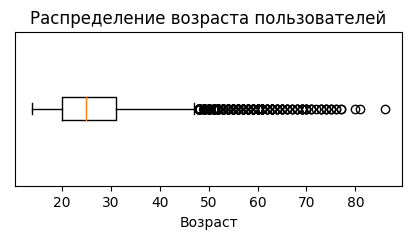

In [1388]:
fig = plt.figure(figsize=(5, 2))
plt.boxplot(client_ids.map(min_age_by_id), vert=False);
plt.xlabel('Возраст')
plt.yticks([])
plt.title('Распределение возраста пользователей');
print(f'Median: {cbook.boxplot_stats(client_ids.map(min_age_by_id))[0]["med"]}')

In [1389]:
stats = cbook.boxplot_stats(client_ids.map(min_age_by_id))
lower_threshold = stats[0]['whislo']
upper_threshold = stats[0]['whishi']

print(f"Lower threshold: {lower_threshold}")
print(f"Upper threshold: {upper_threshold}")
deleted = client_ids.shape[0] - client_ids[client_ids.map(min_age_by_id).between(lower_threshold, upper_threshold)].shape[0]
print(f'Deleted {deleted} users ({deleted / n_users * 100:.2f}%)')
client_ids = client_ids[client_ids.map(min_age_by_id).between(lower_threshold, upper_threshold)]

Lower threshold: 14
Upper threshold: 47
Deleted 578 users (1.40%)


Median: 25.0

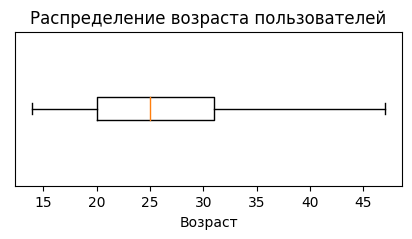

In [1390]:
fig = plt.figure(figsize=(5, 2))
plt.boxplot(client_ids.map(min_age_by_id), vert=False)
plt.xlabel('Возраст')
plt.yticks([])
plt.title('Распределение возраста пользователей');
print(f'Median: {cbook.boxplot_stats(client_ids.map(min_age_by_id))[0]["med"]}')

----

Корректировка уровня образования

In [1391]:
def correct_edu_lvl(cliend_id):
    age = min_age_by_id[cliend_id]
    max_lvl = max([edu_lvl_grade[lvl] for lvl in edu_lvls_by_id[cliend_id]])
    while age < age_by_edu_lvl_treshold[edu_lvl_by_grade[max_lvl]]:
        max_lvl -= 1
    return edu_lvl_by_grade[max_lvl]

In [1392]:
# df['education_level'] = df['client_id'].map(correct_edu_lvl)

----

Обработка дохода

In [1393]:
min_income_by_id = df.groupby('client_id')['monthly_income_amt'].min()
mean_income_by_id = df.groupby('client_id')['monthly_income_amt'].mean()
n_negative_minimal_income = client_ids[client_ids.map(min_income_by_id) < 0].shape[0]
print(f'Users with negative minimal income: {n_negative_minimal_income} ({n_negative_minimal_income / n_users * 100:.2f}%)')
client_ids = client_ids[client_ids.map(min_income_by_id) >= 0]

Users with negative minimal income: 7151 (17.32%)


Median: 80000.0


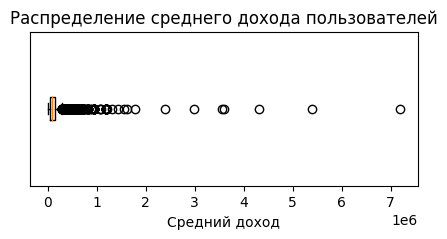

In [1394]:
plt.figure(figsize=(5, 2))
plt.boxplot(client_ids.map(mean_income_by_id), vert=False);
plt.xlabel('Средний доход')
plt.yticks([])
plt.title('Распределение среднего дохода пользователей');
print(
    f'Median: {cbook.boxplot_stats(client_ids.map(mean_income_by_id))[0]["med"]}')

In [1395]:
stats = cbook.boxplot_stats(client_ids.map(mean_income_by_id))
lower_threshold = stats[0]['whislo']
upper_threshold = stats[0]['whishi']

print(f"Lower threshold: {lower_threshold}")
print(f"Upper threshold: {upper_threshold}")
n_deleted = client_ids.shape[0] - client_ids[client_ids.map(mean_income_by_id).between(lower_threshold, upper_threshold)].shape[0]
print(f'Deleted {n_deleted} users ({n_deleted / n_users * 100:.2f}%)')
client_ids = client_ids[client_ids.map(mean_income_by_id).between(lower_threshold, upper_threshold)]

Lower threshold: 32.0
Upper threshold: 298916.0
Deleted 1585 users (3.84%)


Median: 74000.0


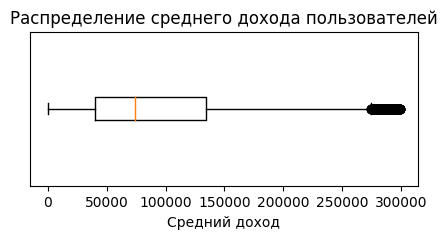

In [1396]:
plt.figure(figsize=(5, 2))
plt.boxplot(client_ids.map(mean_income_by_id), vert=False)
plt.xlabel('Средний доход')
plt.yticks([])
plt.title('Распределение среднего дохода пользователей')
print(
    f'Median: {cbook.boxplot_stats(client_ids.map(mean_income_by_id))[0]["med"]}')

In [1397]:
stats = cbook.boxplot_stats(client_ids.map(mean_income_by_id))
lower_threshold = stats[0]['whislo']
upper_threshold = stats[0]['whishi']

print(f"Lower threshold: {lower_threshold}")
print(f"Upper threshold: {upper_threshold}")
n_deleted = client_ids.shape[0] - client_ids[client_ids.map(
    mean_income_by_id).between(lower_threshold, upper_threshold)].shape[0]
print(f'Deleted {n_deleted} users ({n_deleted / n_users * 100:.2f}%)')
client_ids = client_ids[client_ids.map(
    mean_income_by_id).between(lower_threshold, upper_threshold)]

Lower threshold: 32.0
Upper threshold: 274400.0
Deleted 638 users (1.54%)


----

(не)Убираем людей у которых мало покупок

In [1398]:
# count_of_purchases_by_id = df.groupby('client_id')['good_name'].count()
# n_less_3 = client_ids[client_ids.map(lambda x: count_of_purchases_by_id[x] <= 3)].shape[0]
# print(f'Users with less than 3 purchases: {n_less_3} ({n_less_3 / n_users * 100:.2f}%)')
# client_ids = client_ids[client_ids.map(lambda x: count_of_purchases_by_id[x] > 3)]

----

In [1399]:
df = df[df['client_id'].isin(client_ids)]

Осталось после чистки

In [1400]:
print(f'Rows: {len(df)}, {len(df) / n_purchases * 100:.2f}% from original')
print(f'Clients: {len(client_ids)}, {len(client_ids) / n_users * 100:.2f}% from original')

Rows: 63242, 71.30% from original
Clients: 30064, 72.80% from original


----

Некоторая статистика по оставшимся пользователям

In [1401]:
dlc_to_all_ratio_by_id = df.groupby('client_id')['is_DLC'].mean()

mean_good_price_by_id = df.groupby(['client_id', 'id'])['good_price'].sum().groupby('client_id').mean()

# Анализ

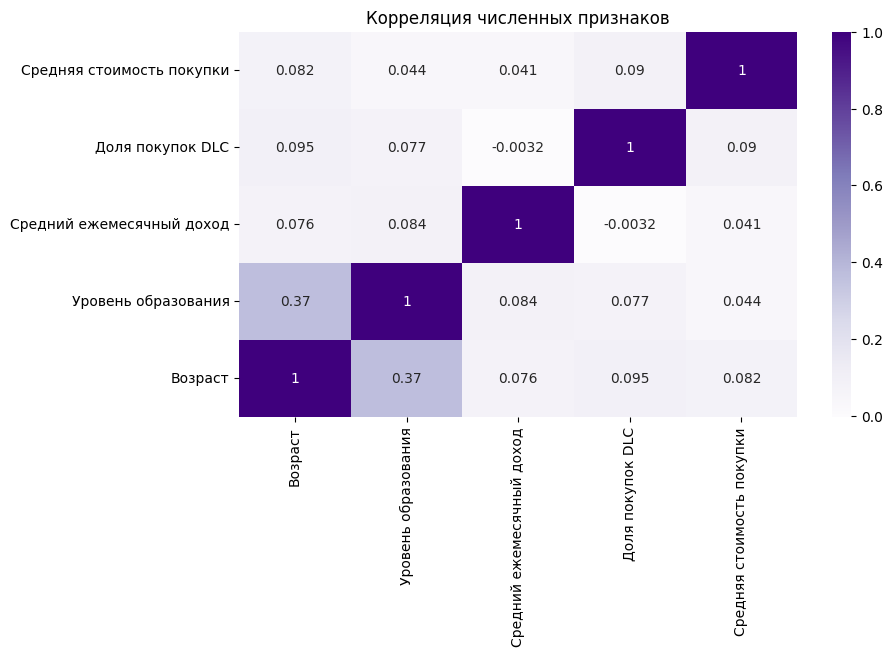

In [1402]:
fig = plt.figure(figsize=(9, 5))
numeric_features = pd.DataFrame({'Возраст': client_ids.map(min_age_by_id), 'Уровень образования': client_ids.map(correct_edu_lvl).apply(lambda x: edu_lvl_grade[x]), 'Средний ежемесячный доход': client_ids.map(mean_income_by_id), 'Доля покупок DLC': client_ids.map(dlc_to_all_ratio_by_id), 'Средняя стоимость покупки': client_ids.map(mean_good_price_by_id)})
correlation_matrix = numeric_features.corr()
sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.Purples)
plt.gca().invert_yaxis()
plt.title('Корреляция численных признаков')
plt.show()

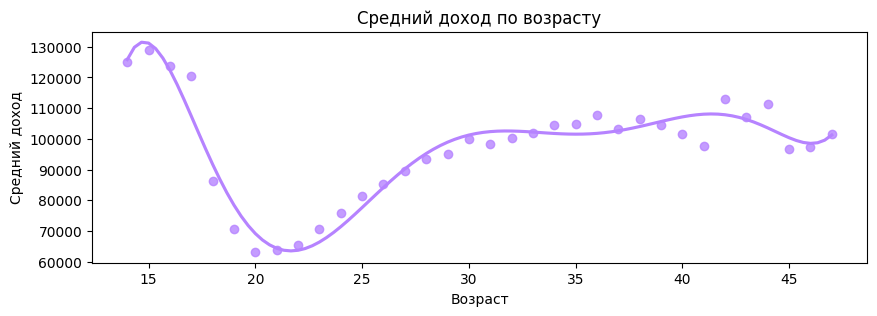

In [1403]:
plt.figure(figsize=(10, 3))
df1 = pd.DataFrame({'age': client_ids.map(min_age_by_id),
                   'mean income': client_ids.map(mean_income_by_id)})

df1 = df1[df1['age'].between(14, 50)]
df2 = df1.groupby('age')['mean income'].mean().reset_index()
sns.regplot(x='age', y='mean income', data=df2, order=7,
            ci=None, color=graphics_color)

plt.xlabel('Возраст')
plt.ylabel('Средний доход')
plt.title('Средний доход по возрасту')
plt.show()

In [1404]:
def find_w0_w1(x, y):
    w1 = ((x - x.mean()) * (y - y.mean())).sum() / ((x - x.mean()) ** 2).sum()
    w0 = y.mean() - w1 * x.mean()
    return w0, w1

In [1405]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm

Регрессия по возрасту

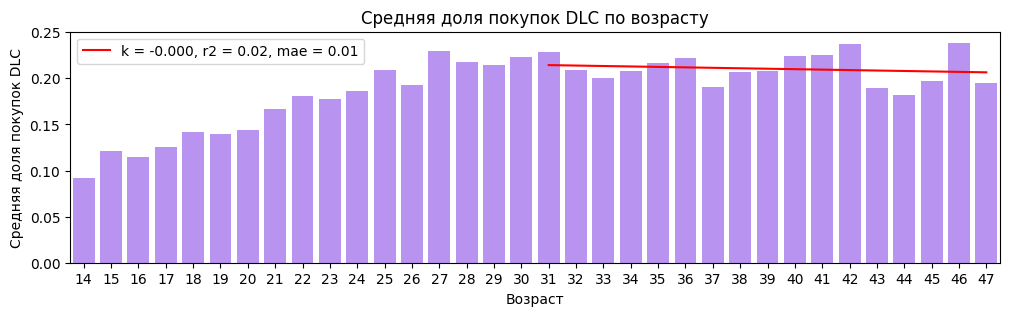

In [1406]:
# age_groups = [(14, 31), (31, 47)]
age_groups = [(31, 47)]

plt.figure(figsize=(12, 3))

df1 = pd.DataFrame({'age': client_ids.map(min_age_by_id), 'dlc_to_all_ratio': client_ids.map(dlc_to_all_ratio_by_id)})

df1 = df1.groupby('age')['dlc_to_all_ratio'].mean().reset_index()

for min_age, max_age in age_groups:
    x = np.arange(min_age, max_age + 1)
    y = df1[df1['age'].between(min_age, max_age)]['dlc_to_all_ratio'].values

    w0, w1 = find_w0_w1(x, y)
    
    annot = f'k = {w1:.3f}, r2 = {r2_score(y, w0 + w1 * x):.2f}, mae = {mean_absolute_error(y, w0 + w1 * x):.2f}'
    plt.plot(x - 14, w0 + w1 * x, label=annot, color = 'red')
    # plt.annotate(annot, (x.mean() - 14, 1.05 * (w0 + w1 * x.mean())), fontsize=12)
    

plt.legend()

plt.title("Средняя доля покупок DLC по возрасту")

df1 = pd.DataFrame({'age': client_ids.map(min_age_by_id),
                   'dlc_to_all_ratio': client_ids.map(dlc_to_all_ratio_by_id)})

df2 = df1.groupby('age')['dlc_to_all_ratio'].mean().reset_index()
sns.barplot(x='age', y='dlc_to_all_ratio', data=df2, color=graphics_color)
plt.xlabel('Возраст')
plt.ylabel('Средняя доля покупок DLC');

In [1407]:
df1 = pd.DataFrame({'age': client_ids.map(min_age_by_id),
                    'dlc_to_all_ratio': client_ids.map(dlc_to_all_ratio_by_id)})

df1 = df1.groupby('age')['dlc_to_all_ratio'].mean().reset_index()
df1 = df1[df1['age'].between(31, 47)]
x = df1['age'].values
y = df1['dlc_to_all_ratio'].values

w0, w1 = find_w0_w1(x, y)

model = sm.OLS(y, sm.add_constant(x)).fit()
print(mean_absolute_error(y, w0 + w1 * x))
print(model.summary())

0.013807834241603692
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.044
Method:                 Least Squares   F-statistic:                    0.3271
Date:                Wed, 20 Dec 2023   Prob (F-statistic):              0.576
Time:                        03:45:23   Log-Likelihood:                 45.906
No. Observations:                  17   AIC:                            -87.81
Df Residuals:                      15   BIC:                            -86.15
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2295      0.03

c:\Users\tibec\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


0.017273012651430445
                            OLS Regression Results                            
Dep. Variable:       dlc_to_all_ratio   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     3.892
Date:                Wed, 20 Dec 2023   Prob (F-statistic):             0.0593
Time:                        03:45:23   Log-Likelihood:                 65.843
No. Observations:                  28   AIC:                            -127.7
Df Residuals:                      26   BIC:                            -125.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2215      0.00

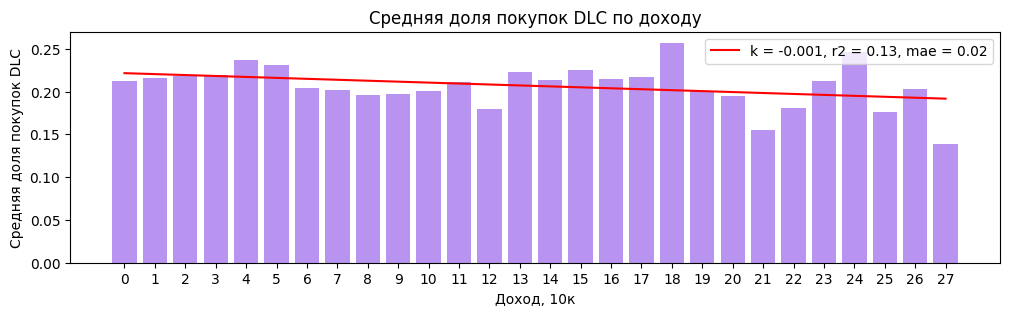

In [1408]:
plt.figure(figsize=(12, 3))
plt.title("Средняя доля покупок DLC по доходу")


df1 = pd.DataFrame({'income': client_ids.map(mean_income_by_id),
                   'dlc_to_all_ratio': client_ids.map(dlc_to_all_ratio_by_id), 'age' : client_ids.map(min_age_by_id)})

df1 = df1[df1['age'].between(31, 47)]
df1.drop('age', axis=1, inplace=True)

df1['income'] = df1['income'].apply(lambda x: int(x / 10000))
df1 = df1.groupby('income')['dlc_to_all_ratio'].mean().reset_index()
bars = sns.barplot(x='income', y='dlc_to_all_ratio', data=df1, color=graphics_color)
plt.xlabel('Доход, 10к')
plt.ylabel('Средняя доля покупок DLC')

x = df1['income']
y = df1['dlc_to_all_ratio']

model = sm.OLS(y, sm.add_constant(x)).fit()

w0, w1 = find_w0_w1(x, y)
print(mean_absolute_error(y, w0 + w1 * x))
plt.plot(x, w0 + w1 * x, color='red', label=f'k = {w1:.3f}, r2 = {r2_score(y, w0 + w1 * x):.2f}, mae = {mean_absolute_error(y, w0 + w1 * x):.2f}')
plt.legend()
print(model.summary())

Z-test

In [1409]:

from scipy.stats import norm

df1 = pd.DataFrame({'edu_lvl': client_ids.map(correct_edu_lvl), 'dlc_ratio' : client_ids.map(dlc_to_all_ratio_by_id), 'age' : client_ids.map(min_age_by_id)})
df1 = df1[df1['age'].between(31, 46)]
df1['edu_lvl'] = df1['edu_lvl'].apply(lambda x: 'UGR/SCH' if x in ['UGR', 'SCH'] else 'PGR/GRD/ACD')
mean_dlc_to_all_ratio = df1.groupby('edu_lvl')['dlc_ratio'].mean()

def z_test(lvl1, lvl2):
    p1, p2 = mean_dlc_to_all_ratio[lvl1], mean_dlc_to_all_ratio[lvl2]
    n1, n2 = df1[df1['edu_lvl'] ==
                 lvl1].shape[0], df1[df1['edu_lvl'] == lvl2].shape[0]

    p = (p1 * n1 + p2 * n2) / (n1 + n2)
    z = (p1 - p2) / (p * (1 - p) * (1 / n1 + 1 / n2)) ** 0.5

    p_value = 1 - norm.cdf(abs(z))

    return p_value, z


edu_lvls = df1['edu_lvl'].drop_duplicates()
p_values = pd.DataFrame(index=edu_lvls, columns=edu_lvls)
diff_df = pd.DataFrame(index=edu_lvls, columns=edu_lvls)
for lvl1 in edu_lvls:
    for lvl2 in edu_lvls:
        p, z = z_test(lvl1, lvl2)
        
        p_values.loc[lvl1, lvl2] = f'{p:.2f}' + " " + f'{z:.2f}'
        if p < 0.05:
            diff_df.loc[lvl1, lvl2] = '>' if z > 0 else '<'
        else:
            diff_df.loc[lvl1, lvl2] = '-'

p_values

edu_lvl,PGR/GRD/ACD,UGR/SCH
edu_lvl,,
PGR/GRD/ACD,0.50 0.00,0.01 2.54
UGR/SCH,0.01 -2.54,0.50 0.00


In [1410]:
diff_df

edu_lvl,PGR/GRD/ACD,UGR/SCH
edu_lvl,,
PGR/GRD/ACD,-,>
UGR/SCH,<,-


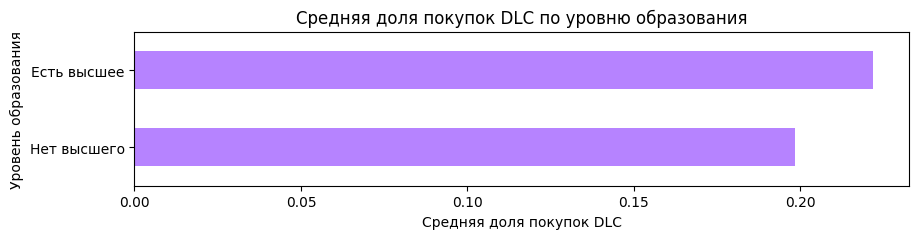

In [1411]:
plt.figure(figsize=(10, 2))

df1 = pd.DataFrame({'edu_lvl': client_ids.map(correct_edu_lvl), 'dlc_ratio' : client_ids.map(dlc_to_all_ratio_by_id), 'age' : client_ids.map(min_age_by_id)})
df1 = df1[df1['age'].between(31, 46)]
df1['edu_lvl'] = df1['edu_lvl'].apply(
    lambda x: 'Нет высшего' if x in ['SCH', 'UGR'] else 'Есть высшее')
df1.groupby('edu_lvl')['dlc_ratio'].mean().sort_values().plot(kind='barh', color=graphics_color)
plt.xlabel('Средняя доля покупок DLC')
plt.ylabel('Уровень образования')
plt.title('Средняя доля покупок DLC по уровню образования');